[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_CAMS.png)](https://atmosphere.copernicus.eu)

# CAMS Regional Air Quality Forecast Practical

**Run the tutorial via free cloud platforms**: [![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/cams-act6/main?labpath=03-model/cams-regional-forecast.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/cams-act6/blob/main/03-model/cams-regional-forecast.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/cams-act6/blob/main/03-model/cams-regional-forecast.ipynb)


## Learning objectives

In this practical exercise you will download CAMS Regional Air Quality Forecast data. You will then calculate the daily max and mean values from a 96 hour forecast of surface ozone concentration and plot these as maps. Finally, you will create a chart of the full 96 hour time series over a specific location.

## Initial setup

Before you begin you must prepare your environment. This includes installing the Application Programming Interface (API) of the Climate Data Store (CDS), intalling any other packages not already installed, setting up your CDS API credentials and importing the various Python libraries that you will need.

In [1]:
# Ensure that the cdsapi package is installed
!pip install -q cdsapi

In [2]:
# If you are running this notebook in Colab, uncomment the line below and run this cell.
#!pip install cartopy

### Add your CDS API credentials (optional)

To set up your CDS API credentials, please follow the [instructions here](https://cds-beta.climate.copernicus.eu/how-to-api). 

Alternatively, you can add them to your current session by uncommenting and executing the code in the following cell:

In [23]:
#import os
#os.environ['CDSAPI_URL'] = 'https://ads.atmosphere.copernicus.eu/api/v2'
#os.environ['CDSAPI_KEY'] = '###########################################'

### Import libraries

In [101]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import pandas as pd
import xarray as xr

# Manipulate dates and times
import datetime

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

Here you specify a data directory in which you will download your data and all output files that you will generate:

In [1]:
DATADIR = '.'

## Explore and download data

The download form for the CAMS regional forecast data can be found here https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=form. However, we will download the data programmatically, using the parameters specified in the following code cells. 

**Please remember to accept the terms and conditions at the bottom of the download form.**


### Specify parameters of data request

In [103]:
cams_dataset = 'cams-europe-air-quality-forecasts'
start_date = '2024-07-30'
end_date = '2024-07-30'
time = '00:00'
lead_time_start = 0
lead_time_stop = 96
step_hours = 1
leadtime_hours = list(range(lead_time_start, lead_time_stop + lead_time_start, step_hours))
variables = ['ozone']
models = ['ensemble']
levels = [0]

### Create dictionary of request

In [104]:
request = {
        'variable': variables,
		'date': f'{start_date}/{end_date}',
        'time': f'{time}',
        'leadtime_hour': leadtime_hours,
        'type': 'forecast',
        'model': models,
        'level': levels,
        'format': 'netcdf'
    }

### Download data

In [107]:
target = f'{DATADIR}/O3-regional-forecast-20240730.nc'

In [108]:
c = cdsapi.Client()
c.retrieve(cams_dataset, request, target)

2024-09-03 16:09:20,814 INFO Welcome to the CDS
2024-09-03 16:09:20,816 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2024-09-03 16:09:20,979 INFO Request is queued
2024-09-03 16:09:22,037 INFO Request is running
2024-09-03 16:09:25,897 INFO Request is completed
2024-09-03 16:09:25,897 INFO Downloading https://download-0001-ads-clone.copernicus-climate.eu/cache-compute-0001/cache/data9/adaptor.cams_regional_fc.retrieve-1725372563.307897-25936-2-4feb74da-6e8d-4689-b195-9d719de326a5.nc to ./cams-regional-forecast-data/O3-regional-forecast-20240730.nc (107.7M)
2024-09-03 16:09:55,434 INFO Download rate 3.6M/s                                                                      


Result(content_length=112902072,content_type=application/x-netcdf,location=https://download-0001-ads-clone.copernicus-climate.eu/cache-compute-0001/cache/data9/adaptor.cams_regional_fc.retrieve-1725372563.307897-25936-2-4feb74da-6e8d-4689-b195-9d719de326a5.nc)

## Inspect data

In [109]:
# Create Xarray Dataset
ds = xr.open_dataset(target)

# view the dataset
ds

<xarray.Dataset>
Dimensions:    (longitude: 700, latitude: 420, level: 1, time: 96)
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 3 days 23:00:00
Data variables:
    o3_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        O3 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240730+[0H_95H]
    summary:      ENSEMBLE model hourly FORECAST of O3 concentration at the S...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

## Process data

Here you will calculate the daily forecast maximum and mean values. Before doing so, we will carry-out some processing to more easily manage the time dimension.

### Convert time dimension to datetime

In [110]:
delta_forecast = 3600000000000 # delta between one lead time and the next one
num_forecasts = len(leadtime_hours) 
start_day = pd.to_datetime(start_date)
forecast_index = start_day + pd.to_timedelta(np.arange(num_forecasts), 'H')

In [111]:
ds_dt = ds.assign_coords(time=forecast_index)
ds_dt

<xarray.Dataset>
Dimensions:    (longitude: 700, latitude: 420, level: 1, time: 96)
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2024-07-30 ... 2024-08-02T23:00:00
Data variables:
    o3_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        O3 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240730+[0H_95H]
    summary:      ENSEMBLE model hourly FORECAST of O3 concentration at the S...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [112]:
# create xarray data array object (single variable)
da = ds_dt['o3_conc']
da

<xarray.DataArray 'o3_conc' (time: 96, level: 1, latitude: 420, longitude: 700)>
[28224000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2024-07-30 ... 2024-08-02T23:00:00
Attributes:
    species:        Ozone
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_ozone_in_air

### Calculate daily max and mean concentrations

In [113]:
o3_daily_max = da.resample(time='D').max()
o3_daily_mean = da.resample(time='D').mean()

## Plot forecast maps

In [114]:
def plot_forecasts(xarray_da, num_forecasts, plot_title):
    '''
    Creates a plot of a data array
    '''
    fig, axs = plt.subplots(4, 1, figsize = (10, 40), 
                            subplot_kw={'projection': ccrs.Orthographic(central_latitude=60)})
    
    day_forecasts = xarray_da.time.values
    for i in range(num_forecasts):
        timestamp = day_forecasts[i]
        day = str(timestamp)[:10]
        data = xarray_da.sel(time=day, level=0.0)
        cs = axs[i].pcolormesh(xarray_da.longitude, 
                               xarray_da.latitude, 
                               data,  
                               cmap='RdYlBu_r', #'YlOrRd' 
                               transform=ccrs.PlateCarree())
    
        cbar = plt.colorbar(cs, fraction=0.046, pad=0.05, orientation='vertical', shrink=0.75)
        cbar.set_label(' $\mu g \cdot m^{-3}$')
        axs[i].set_title(plot_title + day)
        axs[i].coastlines(color='black', alpha=0.7) 
        axs[i].gridlines(draw_labels=False, linestyle='--')
        axs[i].margins(0.5)

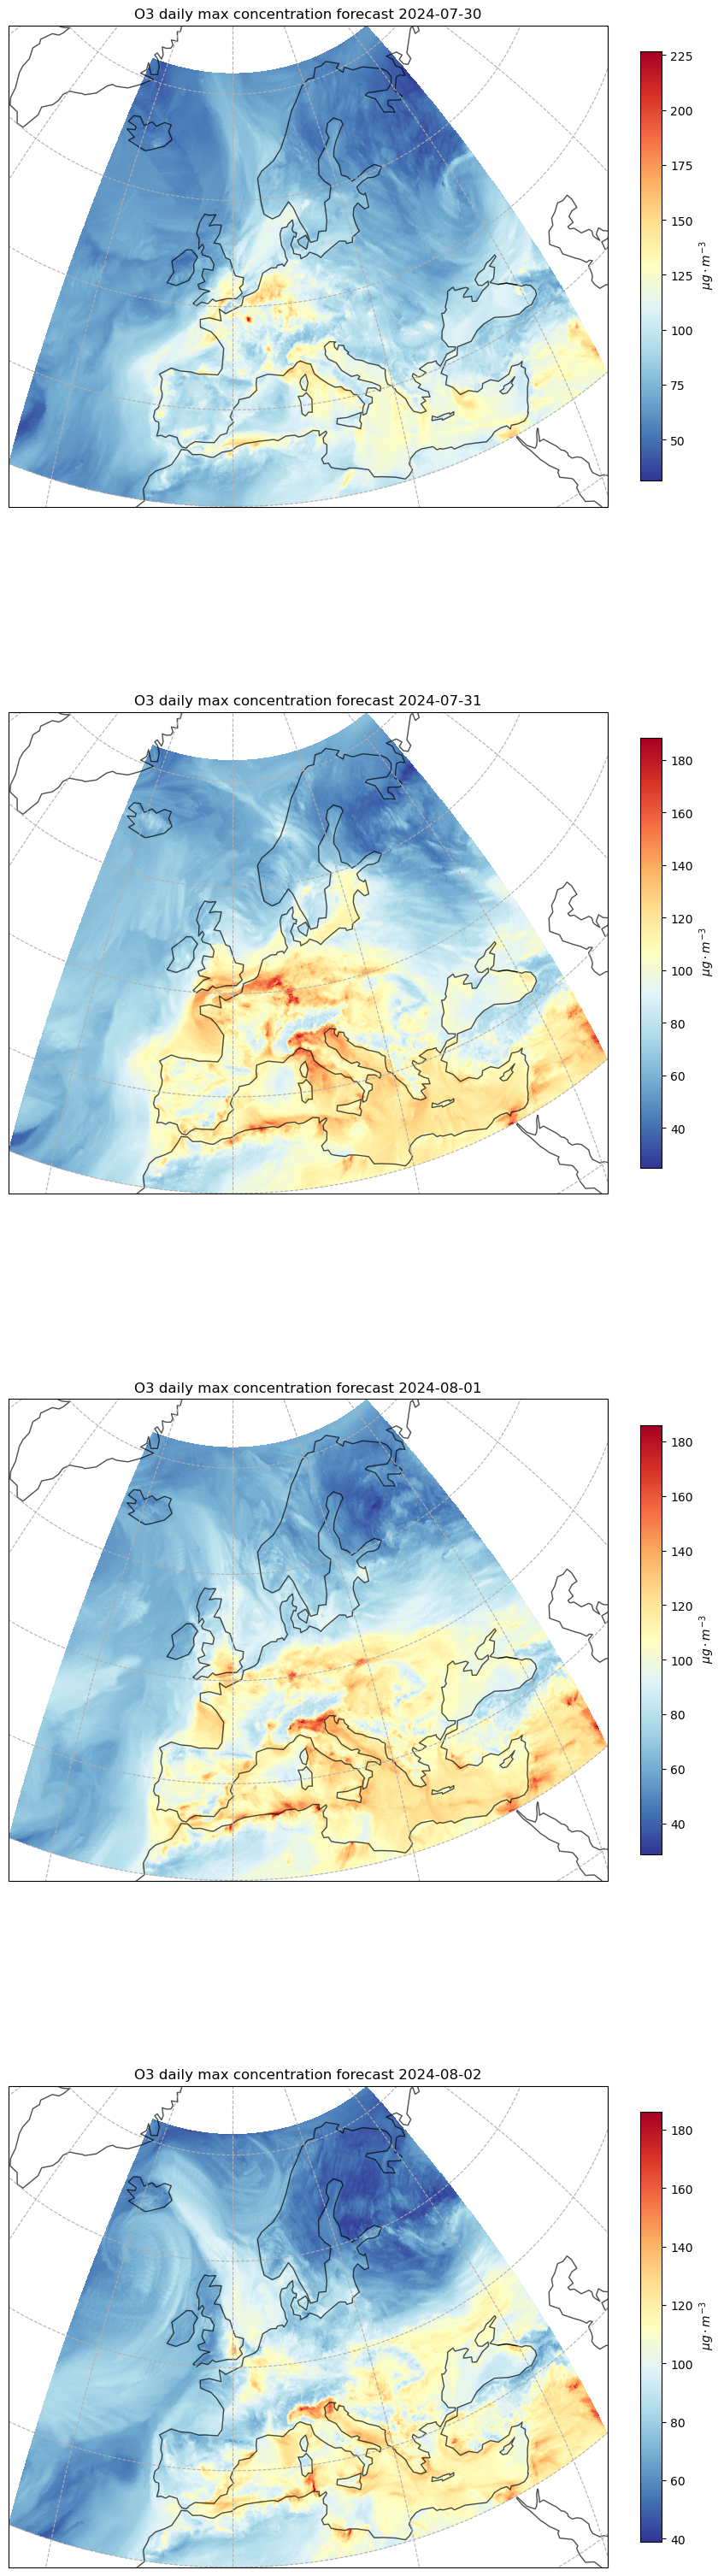

In [115]:
plot_forecasts(o3_daily_max, 4, 'O3 daily max concentration forecast ')

## Plot time series for given latitude and longitude

### Convert longitude to [-180, 180] grid

Notice that the `longitude` variables in the Xarray Dataset and Data Array objects are in the range of `[0, 359.75]`. By default, ECMWF data are on a [0, 360] grid. Should you wish to, there are two options to bring the longitude coordinates to a `[-180, 180]` grid. The first option, in case you already have the data downloaded, is to assign values to coordinates with the xarray function `assign_coords()`. The code below shifts your longitude coordinates from `[0, 359.75]` to `[-180, 179.75]`.

The second option is to specify the `area` keyword argument right when you request data with the `CDS API`. The `area` keyword then automatically reprojects the requested data onto a [-180, 180] grid.

In [116]:
ds_180 = ds_dt.assign_coords(longitude=(((ds_dt.longitude + 180) % 360) - 180)).sortby('longitude')

In [117]:
da = ds_180['o3_conc']
da

<xarray.DataArray 'o3_conc' (time: 96, level: 1, latitude: 420, longitude: 700)>
[28224000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2024-07-30 ... 2024-08-02T23:00:00
Attributes:
    species:        Ozone
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_ozone_in_air

### Select location

In [118]:
oslo_lat = 59.91 
oslo_lon = 10.73

In [119]:
oslo_da = da.sel(latitude = oslo_lat, longitude = oslo_lon, method='nearest', level=0.0)
oslo_da

<xarray.DataArray 'o3_conc' (time: 96)>
[96 values with dtype=float32]
Coordinates:
    longitude  float32 10.75
    latitude   float32 59.95
    level      float32 0.0
  * time       (time) datetime64[ns] 2024-07-30 ... 2024-08-02T23:00:00
Attributes:
    species:        Ozone
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_ozone_in_air

### Plot time series

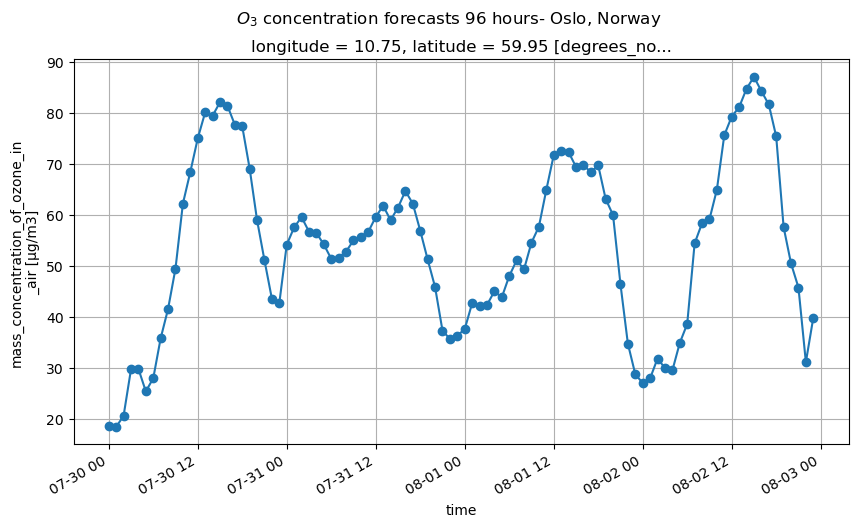

In [120]:
fig = plt.figure(figsize=(10, 5))
oslo_da.plot(marker='o')
plt.suptitle("$O_3$ concentration forecasts 96 hours- Oslo, Norway")
plt.grid(True)

For more analysis of this event, visit https://atmosphere.copernicus.eu/cams-air-boreal-summer-24